# Test DJI SDK sensitivity to conversion parameters

In [1]:
import os
from dji_thermal_sdk.dji_sdk import *
from dji_thermal_sdk.utility import rjpeg_to_heatmap, rjpeg_to_thermal
import dji_thermal_sdk.dji_sdk as DJI
import ctypes as CT
from ctypes import *

import codecs
import numpy as np
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# *** INITIALIZE AND TEST THE LIBRARY *** 
dji_path = '../mavic_helper/dji_sdk/libdirp.dll'
dji_init(dji_path)

#rjpeg = './tests/client_samples/mavic/DJI_20231129130453_0001_T.JPG'
rjpeg = '../tests/client_samples/mavic/DJI_20240828150821_0123_T.JPG'

In [3]:
def process_rjpeg(rjpeg, distance=None, temperature=None, humidity=None, emissivity=None):
    with open(rjpeg, 'rb') as f:
        content = f.read()

    # create a buffer for the rjpeg contents
    rjpeg_data = CT.create_string_buffer(len(content))
    rjpeg_data.value = content

    # create an image handle
    ret = dirp_create_from_rjpeg(rjpeg_data, len(content), CT.byref(DIRP_HANDLE))
    if ret != 0:
        print(f'Failed at dirp_create_from_rjpeg(): ret = {ret}')

    # get the existing measurement params from the image
    params = dirp_measurement_params_t()
    ret = dirp_get_measurement_params(DIRP_HANDLE, CT.byref(params))
    if ret != 0:
        print(f'Failed at dirp_get_measurement_params(): ret = {ret}')
    print(f'Stored params: {{ distance: {params.distance:.1f}, humidity: {params.humidity:.1f}, emissivity: {params.emissivity:.2f}, reflection: {params.reflection:.1f} }}')

    # set the new params
    if distance:
        params.distance = distance
    if temperature:
        params.reflection = temperature
    if humidity:
        params.humidity = humidity
    if emissivity:
        params.emissivity = emissivity
        
    ret = dirp_set_measurement_params(DIRP_HANDLE, CT.byref(params))
    if ret != 0:
        print(f'Failed at dirp_set_measurement_params(): ret = {ret}')

    print(f'Updated params: {{ distance: {params.distance:.1f}, humidity: {params.humidity:.1f}, emissivity: {params.emissivity:.2f}, reflection: {params.reflection:.1f} }}')

    # create a buffer for the new image  
    resolution = dirp_resolution_t()
    ret = dirp_get_rjpeg_resolution(DIRP_HANDLE, CT.byref(resolution))
    if ret != 0:
        print("Failed dirp_get_rjpeg_resolution(): ret = {ret}")

    buffer_size = resolution.height * resolution.width * CT.sizeof(c_float)
    image_buffer = CT.create_string_buffer(buffer_size)

    # convert the image
    ret = dirp_measure_ex(DIRP_HANDLE, CT.byref(image_buffer), buffer_size)
    if ret != 0:
        print('Failed dirp_measure_ex(): ret = {ret}')

    # get result data from the buffer and reshape
    arr = np.frombuffer(image_buffer, dtype=np.float32)
    image = np.reshape(arr, (resolution.height, resolution.width))

    return image

In [4]:
# process the data using the params stored in the rjpeg
img_default = process_rjpeg(rjpeg)

Stored params: { distance: 5.0, humidity: 50.0, emissivity: 0.95, reflection: 25.0 }
Updated params: { distance: 5.0, humidity: 50.0, emissivity: 0.95, reflection: 25.0 }


In [5]:
print(f'Temperature mean: {img_default.mean():.1f}, min: {img_default.min():.1f}, max: {img_default.max():.1f}')

Temperature mean: 31.7, min: 18.5, max: 46.0


## Where to get parameters

The conversion from sensor radiometric values to temperature requires input parameters for object distance, humidity, temperature, and emissivity. Variations in the parameters can potentially make a considerable difference to the resulting temperatures, depending upon your intent. Ideally you would have the values at the time of image acquisition, especially in an outdoor environment where the conditions can change significantly over short periods of time. This may not always be feasible, as when acquiring drone images, unless you have continuous monitoring data to use.

If you need ballpark parameters for a past date the Weather Underground station map can prove useful. Here is station KPAMANHE51 near Root's Market in Lancaster, PA:

<https://www.wunderground.com/weather/us/pa/manheim/KPAMANHE51>

Personal weather stations like these have daily dashboard pages that plot parameters over time. The URL for station KPAMANHE51 on 2024-05-22 looks like so:

<https://www.wunderground.com/dashboard/pws/KPAMANHE51/graph/2024-05-22/2024-05-22/daily>

Scroll down to see the temperature plot for the day. The same plot includes dewpoint which you can use, along with temperature, to calculate relative humidity.

<https://www.wpc.ncep.noaa.gov/html/dewrh.shtml>

or as explained here:

<https://geoscience.blog/how-to-calculate-relative-humidity-from-temperature-dew-point-and-pressure/>


In [6]:
distance = 25.0
temperature = 25
humidity = 50
emissivity = 0.95

image_true = process_rjpeg(rjpeg, distance=distance, temperature=temperature, humidity=humidity, emissivity=emissivity)

Stored params: { distance: 5.0, humidity: 50.0, emissivity: 0.95, reflection: 25.0 }
Updated params: { distance: 25.0, humidity: 50.0, emissivity: 0.95, reflection: 25.0 }


In [7]:
distance = 20.0
temperature = 25
humidity = 50
emissivity = 0.95

image = process_rjpeg(rjpeg, distance=distance, temperature=temperature, humidity=humidity, emissivity=emissivity)

Stored params: { distance: 5.0, humidity: 50.0, emissivity: 0.95, reflection: 25.0 }
Updated params: { distance: 20.0, humidity: 50.0, emissivity: 0.95, reflection: 25.0 }


In [8]:
print(f'Temperature mean: {image.mean():.1f}, min: {image.min():.1f}, max: {image.max():.1f}')

Temperature mean: 32.7, min: 17.5, max: 48.9


(17.499018, 48.933495)


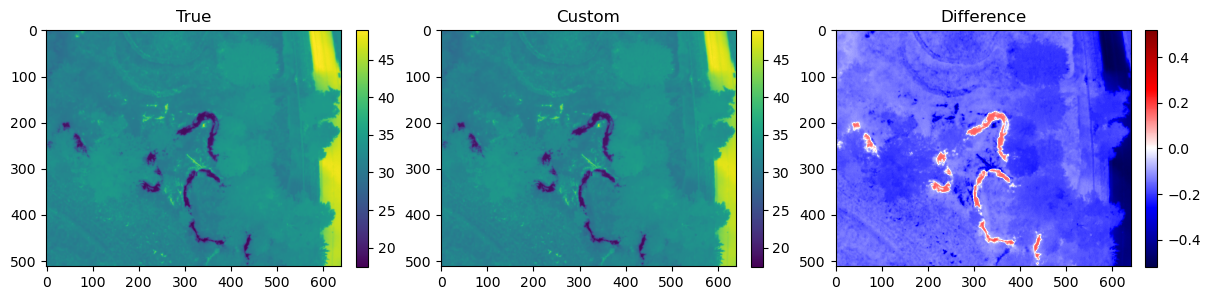

In [9]:
# *** MAKE PLOT ***
image_set = np.concatenate([img_default, image])
image_range = (np.min(image_set), np.max(image_set))
print(image_range)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (12,6) , layout='constrained')

im1 = axs[0].imshow(image_true, cmap='viridis', vmin=image_range[0], vmax=image_range[1])
im2 = axs[1].imshow(image, cmap='viridis', vmin=image_range[0], vmax=image_range[1])
diff = axs[2].imshow(image - image_true, cmap='seismic', norm=colors.CenteredNorm())

axs[0].set_title('True')
axs[1].set_title('Custom')
axs[2].set_title('Difference')

fig.colorbar(im1, ax=axs[0], shrink=0.4);
fig.colorbar(im2, ax=axs[1], shrink=0.4);
fig.colorbar(diff, ax=axs[2], shrink=0.4);

plt.show()